In [1]:
import numpy as np 
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax

In [ ]:
'''Jax implementation of the SMC sampler. Currently bugged. '''

In [2]:
rng_key = jax.random.PRNGKey(1)

b = 5
sigma = 1

@jax.jit
def P(X):
    return jnp.exp(-(X[...,0]**2 + (X[...,1]- b * (X[...,0]**2 - sigma**2)))**2)/2

##Define the sequence of intermediate targets
beta_t = jnp.linspace(0,1,50)


In [3]:
@jax.jit
def log_jacob(weights): 

    #Counter and the carry value from previous iteration
    def scan_body(carry,i): 
        inter = jnp.max(jnp.array([weights[i],carry])) + jnp.log(1 + jnp.exp(-1 * jnp.abs(carry - weights[i])))
        return (inter,inter)

    #Index array to scan over
    xs = jnp.arange(1,weights.shape[0],dtype = jnp.int32)

    #body function, scan array, init_carry
    final,stack = jax.lax.scan(scan_body,jnp.float32(weights[0]),xs)

    return final,stack

In [4]:
@jax.jit
def resampling(key,weights): 
    #Compute cdf
    cdf = jnp.cumsum(weights)

    #Draw the random number
    u_key,key = jax.random.split(key)
    u = jax.random.uniform(key = u_key,minval = 0.,maxval = 1/weights.shape[0])

    #j is the outer loop index over the particles, i is the inner loop index that gives the element in the array to resample
    def scan_body(i,j): 
        u_j = u + (j/weights.shape[0]) #Jth spoke offset

        #Terminates the inner while loop if i less than num particles and u_j greater than cdf_log[i] 
        def cond_fun(loop_vars): 
            i, _ = loop_vars 
            return jnp.logical_and(i < weights.shape[0],u_j > cdf[i])
        
        #Increment the i counter
        def body_fun(loop_vars): 
            i,_ = loop_vars
            return (i + 1, i)
        
        #The inner loop
        i,_ = jax.lax.while_loop(cond_fun, body_fun, (i,i))

        return i, i 
    
    _, indices = jax.lax.scan(scan_body,0, jnp.arange(weights.shape[0],dtype = jnp.int32))

    return indices

In [5]:
##Algorithm

#Initial proposal particles

rng_key,init_key = jax.random.split(rng_key)

N = 100000
particles = jax.random.multivariate_normal(init_key, jnp.array([0,0]),jnp.eye(2),shape = (N,))

weights = jnp.full((N,),1/N,dtype = jnp.float32)

beta_t1 = 0
for t,beta in enumerate(beta_t[1:]):

    #Resampling step
    rng_key,resample_key = jax.random.split(rng_key)

    indices = resampling(resample_key, weights)

    new_particles = particles[indices,:]
    
    #Mutation/M-Kernel step
    rng_key,mutation_key = jax.random.split(rng_key)
    new_particles = new_particles + jax.random.multivariate_normal(mutation_key,mean = jnp.zeros(2),cov = jnp.eye(2),shape = (N,))
    
    #Compute weights
    weights = (P(new_particles)**beta)/(P(particles)**beta_t1)

    particles = new_particles

    # #Normalize weights
    weights = weights / jnp.sum(weights)

    # #Track the previous beta
    beta_t1 = beta

In [6]:
#final reweighting 

rng_key,resample_key = jax.random.split(rng_key)

indices = resampling(resample_key,weights)
particles = particles[indices,:]

mean_estimate = np.mean(particles,axis = 0)
cov_estimate = np.cov(particles.T)

print(f"Estimate of the mean: {mean_estimate}")
print(f"Estimate of the Cov: {cov_estimate}")


Estimate of the mean: [-1.5828512 -8.553694 ]
Estimate of the Cov: [[0. 0.]
 [0. 0.]]


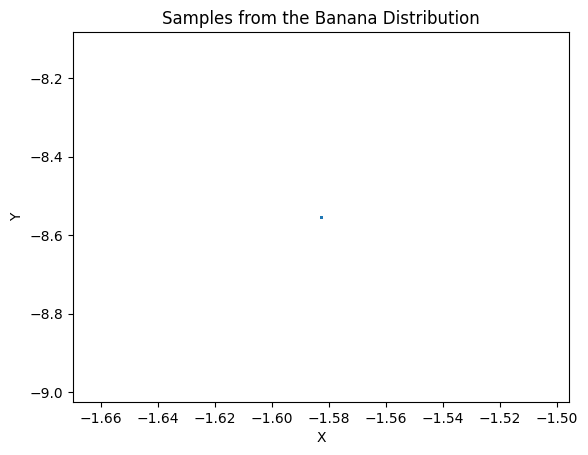

In [7]:
plt.title('Samples from the Banana Distribution')
plt.xlabel('X')
plt.ylabel('Y')

plt.scatter(particles[:,0],particles[:,1],s = 0.1)